In [1]:
from GNNTrain import train, predict_from_saved_model
from CreateDatasetv2_binary import get_dataset_from_graph
from Paths import PATH_TO_GRAPHS, PATH_TO_RANKINGS
from GDARanking import get_ranking, predict_candidate_genes, validate_with_extended_dataset, get_ranking_no_LP_intersection, validate_with_extended_dataset_no_LP
from GraphSageModel import GNN7L_Sage

import pandas as pd

In [2]:
disease_Id  = 'C0006142'
classes     = ['P', 'U']
model_name  = 'GraphSAGE_' + disease_Id + '_new_rankings_binary'
graph_path  = PATH_TO_GRAPHS + 'grafo_nedbit_' + disease_Id + '.gml'

In [3]:
dataset, G = get_dataset_from_graph(graph_path, disease_Id, quartile=False)

[+] Reading graph...ok
[+] Creating dataset...ok
[i] Elapsed time: 34.529


### Train

  0%|          | 0/40001 [00:00<?, ?it/s]

[Epoch: 0000] train loss: 7.6238, train acc: 0.9391, val loss: 3.0384, val acc: 0.9622  (best train acc: 0.9391, best val acc: 0.9622, best train loss: 7.6238  @ epoch 0 )
[Epoch: 0020] train loss: 0.8116, train acc: 0.8965, val loss: 0.3189, val acc: 0.8968  (best train acc: 0.9472, best val acc: 0.9622, best train loss: 0.8116  @ epoch 20 )
[Epoch: 0040] train loss: 0.2996, train acc: 0.9329, val loss: 0.1791, val acc: 0.9551  (best train acc: 0.9472, best val acc: 0.9622, best train loss: 0.2996  @ epoch 40 )
[Epoch: 0060] train loss: 0.2149, train acc: 0.9490, val loss: 0.1580, val acc: 0.9609  (best train acc: 0.9494, best val acc: 0.9622, best train loss: 0.2149  @ epoch 60 )
[Epoch: 0080] train loss: 0.1947, train acc: 0.9503, val loss: 0.1633, val acc: 0.9622  (best train acc: 0.9540, best val acc: 0.9626, best train loss: 0.1923  @ epoch 77 )
[Epoch: 0100] train loss: 0.1743, train acc: 0.9554, val loss: 0.1502, val acc: 0.9619  (best train acc: 0.9558, best val acc: 0.9626, b

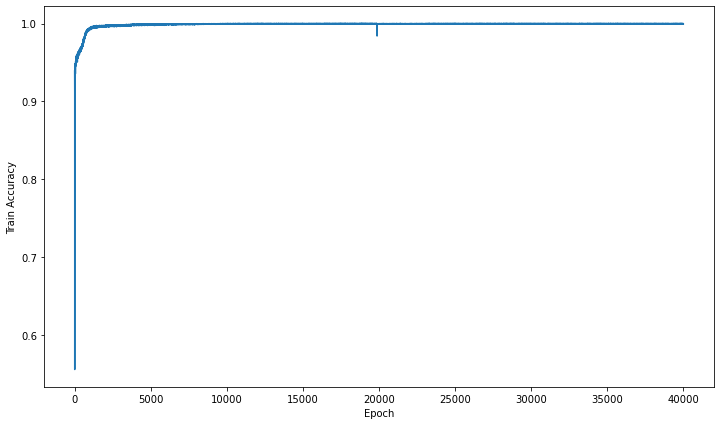

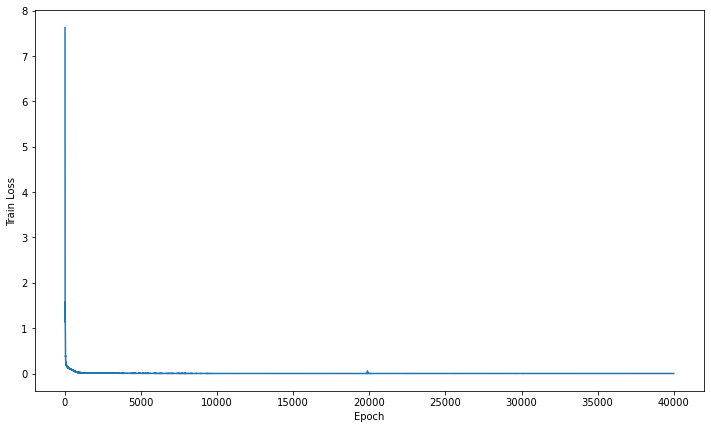

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       112
           1       1.00      1.00      1.00      2852

    accuracy                           1.00      2964
   macro avg       1.00      1.00      1.00      2964
weighted avg       1.00      1.00      1.00      2964



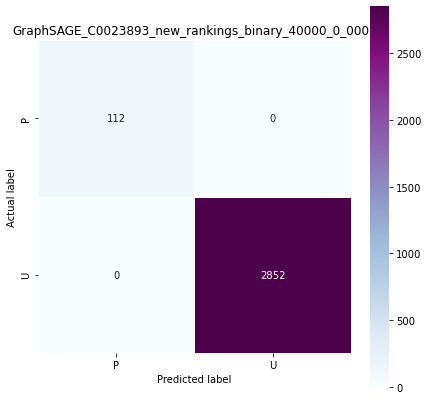

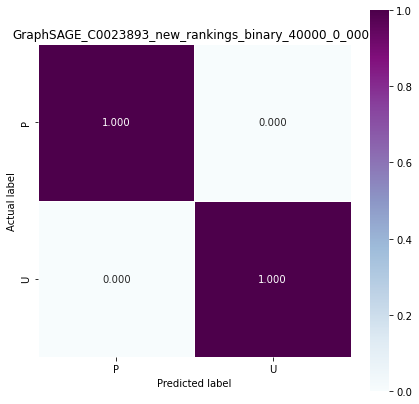

In [4]:
lr              = 0.001
epochs          = 40000
weight_decay    = 0.0005
classes         = ['P', 'U']

model = GNN7L_Sage(dataset)
preds = train(model, dataset, epochs, lr, weight_decay, classes, model_name)

### Get predictions from trained model

In [4]:
preds, probs, model = predict_from_saved_model(model_name + '_40000_0_0005', dataset, classes, save_to_file=False)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       154
           1       1.00      1.00      1.00      2810

    accuracy                           1.00      2964
   macro avg       1.00      1.00      1.00      2964
weighted avg       1.00      1.00      1.00      2964



### Ranking

In [10]:
df = pd.read_csv('precision_positive_genes.csv') 
n_positives = n_positives = df['n_positives'][df[disease_Id].idxmax()]

preds, probs, model = predict_from_saved_model(model_name+'_40000_0_0005', dataset, classes, save_to_file=False, plot_results=False)

ranking = get_ranking(model, dataset, preds, probs, disease_Id, n_positive=n_positives, explanation_nodes_ratio=1, masks_for_seed=10, G=G)

### Save ranking to file
filename = PATH_TO_RANKINGS + disease_Id + '_' + str(n_positives) + '_new_rankings.txt'
with open(filename, 'w') as f:
    for line in ranking:
        f.write(line + '\n')

cuts = [25, 50, 100, 200, 500]
for k in cuts:
    precision = validate_with_extended_dataset(ranking[:k], disease_Id, save_ranking_to_file=False)
    print('[+] Precision on top', k, ':', precision/k)

  0%|          | 0/60 [00:00<?, ?it/s]

[+] Precision on top 25 : 0.72
[+] Precision on top 50 : 0.66
[+] Precision on top 100 : 0.67
[+] Precision on top 200 : 0.625
[+] Precision on top 500 : 0.53


### Ranking - No LP intersection
Considering all genes in explanations subgraph with score >= mean score

In [6]:
df = pd.read_csv('precision_positive_genes.csv') 
n_positives = n_positives = df['n_positives'][df[disease_Id].idxmax()]

preds, probs, model = predict_from_saved_model(model_name+'_40000_0_0005', dataset, classes, save_to_file=False, plot_results=False)

ranking = get_ranking_no_LP_intersection(model, dataset, preds, probs, disease_Id, n_positive=n_positives, explanation_nodes_ratio=1, masks_for_seed=10, G=G)

### Save ranking to file
filename = PATH_TO_RANKINGS + disease_Id + '_' + str(n_positives) + '_new_rankings_no_LP_intersection_10_masks.txt'
with open(filename, 'w') as f:
    for line in ranking:
        f.write(line + '\n')

cuts = [25, 50, 100, 200, 500]
for k in cuts:
    precision = validate_with_extended_dataset_no_LP(ranking[:k], disease_Id, save_ranking_to_file=True)
    print('[+] Precision on top', k, ':', precision/k)

  0%|          | 0/10 [00:00<?, ?it/s]

[+] Precision on top 25 : 0.16
[+] Precision on top 50 : 0.18
[+] Precision on top 100 : 0.13
[+] Precision on top 200 : 0.09
[+] Precision on top 500 : 0.08


### Ranking - No LP intersection all positive genes
Considering all genes in explanations subgraph with score >= mean score. We explain all positive test genes.

In [5]:
ranking = get_ranking_from_all_positives_no_LP_intersection(model, dataset, preds, disease_Id, explanation_nodes_ratio=1, masks_for_seed=5, G=G)

### Save ranking to file
filename = PATH_TO_RANKINGS + disease_Id + '_all_positives_new_ranking_no_lp_intersection.txt'
with open(filename, 'w') as f:
     for line in ranking:
        f.write(line + '\n')

[+] 747 positive nodes found in the graph


  0%|          | 0/747 [00:00<?, ?it/s]

### All positive genes

In [5]:
ranking = predict_candidate_genes(model, dataset, preds, disease_Id, "graphsvx", explanation_nodes_ratio=1, masks_for_seed=5, num_hops = 1, G=G, num_pos="all")

all
[+] 1025 positive nodes found in the graph


  0%|          | 0/1025 [00:00<?, ?it/s]

Explainations only consider graph structure


100it [00:09, 10.87it/s]


53
Explainations only consider graph structure


100it [00:09, 10.49it/s]


59
Explainations only consider graph structure


100it [00:32,  3.09it/s]


334
Explainations only consider graph structure


In [ ]:
### Save ranking to file
filename = PATH_TO_RANKINGS + disease_Id + '_all_positives_new_ranking_xgdag_graphsvx.txt'
with open(filename, 'w') as f:
     for line in ranking:
        f.write(line + '\n')

In [9]:
cuts = [25, 50, 100, 200, 500]
for k in cuts:
    precision = validate_with_extended_dataset(ranking[:k], disease_Id, save_ranking_to_file=False)
    print('[+] Precision on top', k, ':', precision/k)

[+] Precision on top 25 : 0.68
[+] Precision on top 50 : 0.72
[+] Precision on top 100 : 0.66
[+] Precision on top 200 : 0.645
[+] Precision on top 500 : 0.574
